In [1]:
from datetime import datetime
import os
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import warnings
# Ignore UserWarnings from Keras
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [14]:
# Load the dataset and preprocess it for each station
if os.path.isfile('training_data/final_merged_data.csv'):
    data = pd.read_csv("training_data/final_merged_data.csv")
    df = pd.DataFrame()
    
    # choose relevant features, time as index, station_id as index for each station data file
    df['time'] = data['last_reported']
    df['station_id'] = data['station_id']
    df['hour'] = data['hour']
    # estimate average temperature, relative humidity and barometric pressure from max, min and standard deviation
    df['temperature_celsius'] = (data['max_air_temperature_celsius'] + data['min_air_temperature_celsius']) / 2 + (data['air_temperature_std_deviation'] / np.sqrt(3))
    df['relative_humidity_percent'] = (data['max_relative_humidity_percent'] + data['min_relative_humidity_percent']) / 2 + (data['relative_humidity_std_deviation'] / np.sqrt(3))
    df['barometric_pressure_hpa'] = (data['max_barometric_pressure_hpa'] + data['min_barometric_pressure_hpa']) / 2 + (data['barometric_pressure_std_deviation'] / np.sqrt(3))
    # add is_holiday and is_weekend
    ireland_holidays = holidays.country_holidays('IE')
    df['is_holiday'] = data['last_reported'].apply(lambda x: x in ireland_holidays)
    df['is_weekend'] = data['last_reported'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday() in [5, 6])
    # target features
    df['available_bikes'] = data['num_bikes_available']
    df['available_docks'] = data['num_docks_available']
    
    # deal with each station's data by merging hourly data and imputing missing values
    for station_id in df['station_id'].unique():
        df_station = pd.DataFrame(df[df['station_id'] == station_id])
        # station_id is constant column for each station data file, so drop it
        df_station.drop(columns=['station_id'], inplace=True)
        df_station.drop(columns=['time'], inplace=True)
        # Cyclical Encoding for hour feature
        df_station['hour_sin'] = np.sin(2 * np.pi * df_station['hour'] / 23.0).round(6)
        df_station['hour_cos'] = np.cos(2 * np.pi * df_station['hour'] / 23.0).round(6)
        df_station.drop(columns=['hour'], inplace=True)
        # save the data for each station
        df_station.to_csv(f'training_data/station_{station_id}.csv', index=False)
        
    # No available data for station 46
    # so I will not train the model on this station
    station_46 = data[data['station_id']==46]
    if len(station_46)==0:
        print("No data for station 46")

    # all available_bikes and available_docks are 0 for station_51's
    # so I will not train the model on this station
    station_51 = data[data['station_id']==51]
    print(f"Number of rows for station 51: {len(station_51)}")
    if (station_51['num_bikes_available'] == 0).all() and (station_51['num_docks_available'] == 0).all():
        print("All available_bikes and available_docks are 0 for station 51")

    # station_70's data is corrupt, contain only 59 rows of data and all available_bikes and available_docks are 0
    # so I will not train the model on this station
    station_70 = data[data['station_id']==70]
    print(f"Number of rows for station 70: {len(station_70)}")
    if (station_70['num_bikes_available'] == 0).all() and (station_70['num_docks_available'] == 0).all():
        print("All available_bikes and available_docks are 0 for station 70")

    # No available data for station 81
    # so I will not train the model on this station
    station_81 = data[data['station_id']==81]
    if len(station_81)==0:
        print("No data for station 81")


No data for station 46
Number of rows for station 51: 2173
All available_bikes and available_docks are 0 for station 51
Number of rows for station 70: 59
All available_bikes and available_docks are 0 for station 70
No data for station 81


In [3]:
def visualize_prediction(y_test, y_pred, mae_bikes, r2_score_bikes, mae_docks, r2_score_docks, station_id):
    # Plot results for available_bikes
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, 0], label='Actual Bikes', color='green')
    plt.plot(y_pred[:, 0], label='Predicted Bikes', color='red')
    plt.title(f'#{station_id} Station Available Bikes Forecast (MAE: {mae_bikes:.4f}, r2_score: {r2_score_bikes:.4f})')
    plt.xlabel('Hour Sequence')
    plt.ylabel('Available Bikes')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot results for available_docks
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, 1], label='Actual Docks', color='green')
    plt.plot(y_pred[:, 1], label='Predicted Docks', color='red')
    plt.title(f'#{station_id} Station Available Docks Forecast (MAE: {mae_docks:.4f}, r2_score: {r2_score_docks:.4f})')
    plt.xlabel('Hour Sequence')
    plt.ylabel('Available Docks')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_model(station_id, visualize=False):
    # Load the data
    data = pd.read_csv(f'training_data/station_{station_id}.csv')
    X = data.drop(['available_bikes', 'available_docks'], axis=1)
    y = data[['available_bikes', 'available_docks']]

    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X.values, y.values, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Initialize the model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))  # Output layer for two targets

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

    # Fit the model
    model.fit(X_train, y_train, epochs=800, batch_size=32, validation_data=(X_val, y_val), verbose=visualize, callbacks=[early_stopping])

    # Save the model
    model.save(f'trained_model/station_{station_id}_model.keras', include_optimizer=False)

    # Predict using the model
    model = load_model(f'trained_model/station_{station_id}_model.keras')
    y_pred = model.predict(X_test, verbose=visualize)

    # Evaluate each target separately
    mae_bikes = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
    mae_docks = mean_absolute_error(y_test[:, 1], y_pred[:, 1])

    r2_score_bikes = r2_score(y_test[:, 0], y_pred[:, 0])
    r2_score_docks = r2_score(y_test[:, 1], y_pred[:, 1])
    
    if visualize:
        print(f"R2 Score for available_bikes: {r2_score_bikes}")
        print(f"R2 Score for available_docks: {r2_score_docks}")

        print(f"Mean Absolute Error for available_bikes: {mae_bikes}")
        print(f"Mean Absolute Error for available_docks: {mae_docks}")
        
        visualize_prediction(y_test, y_pred, mae_bikes, r2_score_bikes, mae_docks, r2_score_docks, station_id)
        
    return mae_bikes, r2_score_bikes, mae_docks, r2_score_docks

Epoch 1/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 337.5465 - val_loss: 319.7133
Epoch 2/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 326.0164 - val_loss: 302.5930
Epoch 3/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 312.7601 - val_loss: 283.4680
Epoch 4/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 291.2754 - val_loss: 261.5871
Epoch 5/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 273.5060 - val_loss: 234.9044
Epoch 6/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 242.5832 - val_loss: 203.1820
Epoch 7/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 217.8768 - val_loss: 169.9475
Epoch 8/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178.0125 - val_loss: 136.3804
Epoch 9/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149.7162 - val_loss: 108.7139
Epoch 10/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121.0734 - val_loss: 84.9976
Epoch 11/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.0424 - val_loss: 66.5105
Epoch 12/800
64/64 ━━━

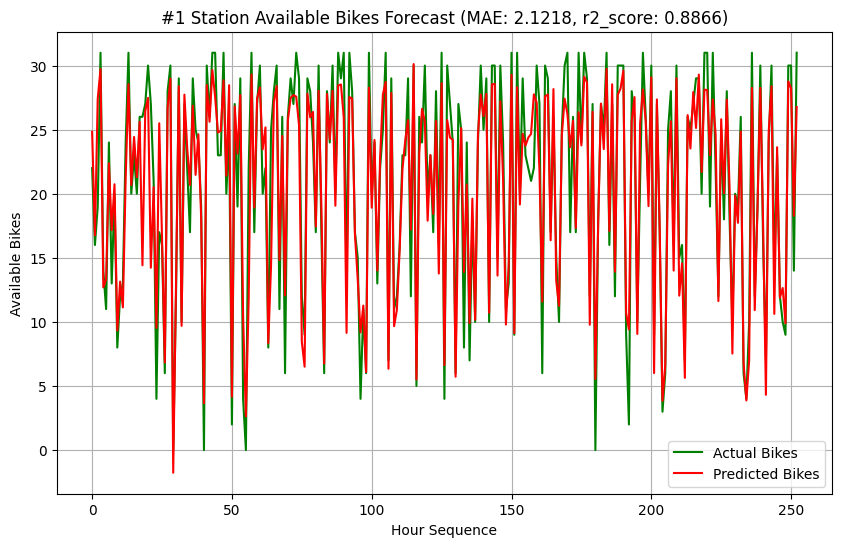

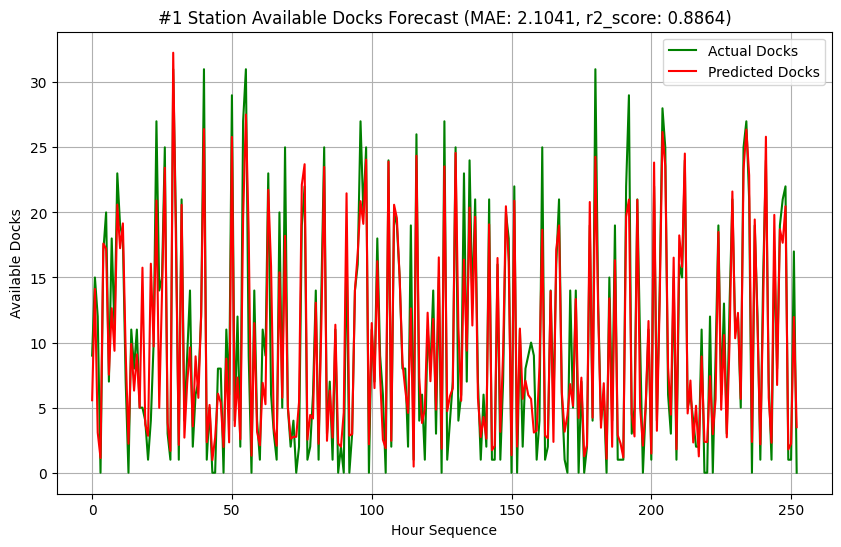

In [ ]:
for station_id in range(1,118):
    if (station_id == 46 or station_id == 51 or station_id == 70 or station_id == 81): # skip these stations due to limited data
        continue
    if (station_id == 1):
        visualize = True # visualize the training process for station 1
    else:
        visualize = False
    mae_bikes, r2_score_bikes, mae_docks, r2_score_docks = train_model(station_id, visualize)
    with open(f'model_results.txt', 'a') as f:
        f.write(f'Station {station_id}: MAE bikes: {mae_bikes}, R2 score bikes: {r2_score_bikes}, MAE docks: {mae_docks}, R2 score docks: {r2_score_docks}\n')